## Introduction

For this session, we will work on this dataset: [DNA Sequence dataset](https://www.kaggle.com/datasets/nageshsingh/dna-sequence-dataset). 
The original guide can be found [here](./resources/dna-sequencing-with-machine-learning.ipynb).

Example of fasta file handling using biopython library:

In [1]:
%matplotlib inline
from pathlib import Path
DATASET_PATH = Path('resources/dna_dataset/')

In [2]:
from Bio import SeqIO
for sequence in SeqIO.parse(DATASET_PATH / 'example_dna.fa', "fasta"):
    print('Sequence ID:', sequence.id)
    print('Sequence:', sequence.seq)
    print('Sequence length:', len(sequence))
    print('-'*20)
    break

Sequence ID: ENST00000435737.5
Sequence: ATGTTTCGCATCACCAACATTGAGTTTCTTCCCGAATACCGACAAAAGGAGTCCAGGGAATTTCTTTCAGTGTCACGGACTGTGCAGCAAGTGATAAACCTGGTTTATACAACATCTGCCTTCTCCAAATTTTATGAGCAGTCTGTTGTTGCAGATGTCAGCAACAACAAAGGCGGCCTCCTTGTCCACTTTTGGATTGTTTTTGTCATGCCACGTGCCAAAGGCCACATCTTCTGTGAAGACTGTGTTGCCGCCATCTTGAAGGACTCCATCCAGACAAGCATCATAAACCGGACCTCTGTGGGGAGCTTGCAGGGACTGGCTGTGGACATGGACTCTGTGGTACTAAATGAAGTCCTGGGGCTGACTCTCATTGTCTGGATTGACTGA
Sequence length: 390
--------------------


## The dataset

**Objective**: Build a classification model that is trained on the human DNA sequence and can predict a gene family based on the DNA sequence of the coding sequence. To test the model, we will use the DNA sequence of humans, dogs, and chimpanzees and compare the accuracies.

Gene families are groups of related genes that share a common ancestor. Members of gene families may be paralogs or orthologs. Gene paralogs are genes with similar sequences from within the same species while gene orthologs are genes with similar sequences in different species.

The dataset contains human DNA sequence, Dog DNA sequence, and Chimpanzee DNA sequence.

## Analyze the dataset

First, we should understand our dataset and objective, before doing any kind of deep dive.

We have 7 classes of gene family, the count of each class here is for the human data only:
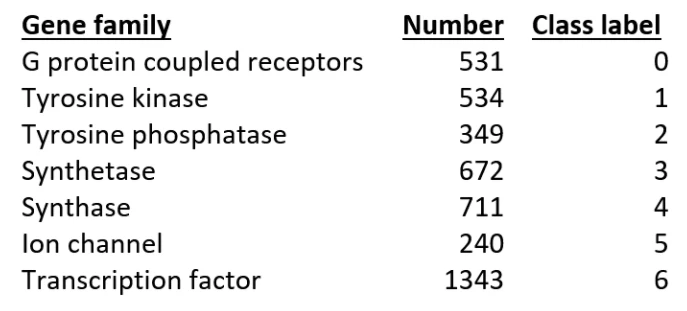

### Class distribution

In [3]:
import pandas as pd
from matplotlib import pyplot as plt

dataset_files = list(DATASET_PATH.glob('*txt'))
print(dataset_files)

[PosixPath('resources/dna_dataset/chimpanzee.txt'), PosixPath('resources/dna_dataset/dog.txt'), PosixPath('resources/dna_dataset/human.txt')]


In [4]:
human_dataframe = pd.read_table(DATASET_PATH / 'human.txt')
chimpanzee_dataframe = pd.read_table(DATASET_PATH / 'chimpanzee.txt')
dog_dataframe = pd.read_table(DATASET_PATH / 'dog.txt')

Text(0.5, 1.0, 'Class distribution of Human DNA')

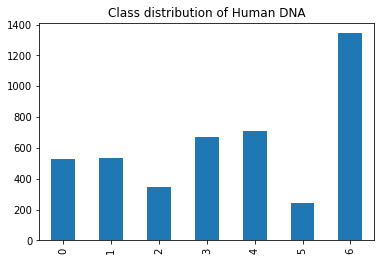

In [5]:
human_dataframe['class'].value_counts().sort_index().plot.bar()
plt.title("Class distribution of Human DNA")

Text(0.5, 1.0, 'Class distribution of Chimpanzee DNA')

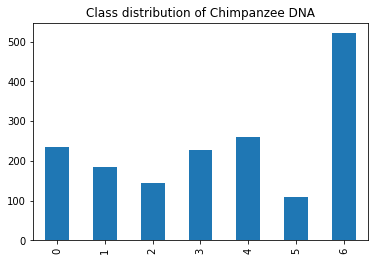

In [6]:
chimpanzee_dataframe['class'].value_counts().sort_index().plot.bar()
plt.title("Class distribution of Chimpanzee DNA")

Text(0.5, 1.0, 'Class distribution of Dog DNA')

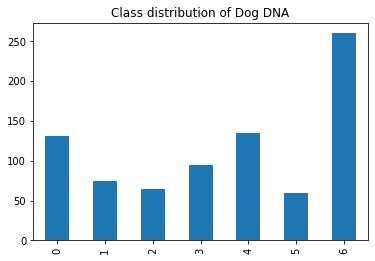

In [7]:
dog_dataframe['class'].value_counts().sort_index().plot.bar()
plt.title("Class distribution of Dog DNA")

The data is a bit skewed with class label 6 having the biggest count. There are ways of dealing with non-uniform class distribution, but for now let's just use the data as is.

### Input size

We want to check if the sequences' sizes are all of the same length. We will use the dog dataset since they have fewer samples.

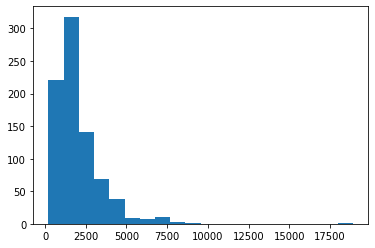

In [8]:
input_sizes = [len(seq) for seq in dog_dataframe['sequence'].tolist()]

_ = plt.hist(input_sizes, bins=20)

A simple histogram of the sequence length shows that the input sizes are variable. We will need to think of a way to deal with this.

## Prepare the dataset

Let's convert this dataset into usable input and load them into a PyTorch Dataset class.

### Encoding the data

As you can see, the current raw data is a string of text with 4 types of characters `ATCG`, but a neural network deals with numbers, hence we have to convert this raw input into such format.

One naive approach is to encode a number to each of the character, such as A is 1, T is 2, C is 3 and G is 4. However, we are introducing unwanted relationship between these 4 bases, like A plus 1 becomes T, which does not make sense biologically.

To make each character independent of each other, we can use one-hot encoding, meaning that each character will have their own "dimension". To put it simply, "ATCG" would become `[0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0], [1, 0, 0, 0]`.

This is indeed a very valid way to encode the data, however, currently we still have the issue with variable size input. We can simply truncate the input, but it will mean we are losing information. There are many other better way to standardize the input size, such as using an embedding layer and using some learned method to convert our input into a fixed size embedding. 

One way of doing in that is to adopt a natural language processing approach and build a fix-sized dictionary. These word are k-mers, with k is a value of our choosing. To simplify the complexity (and ammount of unique word), let choose our k-mers to be 3. Then our dictionary will have 125 words (5 characters, including `N`). We can process these further and create word embeddings (how the words are related to each others), but let put this aside until our NLP session. For now let's just convert our raw inputs into fixed size inputs of shape (1, 125), and the value for each of the word is the frequency of that word in the input.

In [9]:
from itertools import product

In [10]:
def create_dictionary(word_size: int) -> dict[str, int]:
    product_input = ['ATCGN'] * word_size
    return {''.join(seq): index for index, seq 
            in enumerate(product(*product_input))}

In [11]:
word_size = 3
dictionary = create_dictionary(word_size)
print(len(dictionary))

125


In [12]:
import numpy as np

def convert_input(sequence: str, 
                  dictionary: dict[str, int],
                  word_size: int
                 ) -> np.ndarray:
    array = np.zeros((1, len(dictionary)))
    num_kmer = 0
    for i in range(len(sequence) - word_size + 1):
        kmer = sequence[i: i + word_size]
        print(kmer, dictionary[kmer])
        array[0][dictionary[kmer]] += 1
        num_kmer += 1
    return array / num_kmer

In [13]:
convert_input('AAAATGC', dictionary, word_size)

AAA 0
AAA 0
AAT 1
ATG 8
TGC 42


array([[0.4, 0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ]])

Notice how we divide the final array by the total number of kmers in the sequence? This is a form of normalization, because if we don't do that, the sum of the input will also be a variable.

### Create the dataset

In [14]:
import numpy as np
from torch import Tensor
from torch.utils.data.dataset import Dataset


class DnaSeqDataset(Dataset):
    def __init__(self, data_frame: pd.DataFrame, word_size: int) -> None:
        self._word_size = word_size
        self._data_frame = data_frame
        self._dictionary = self._create_dictionary()
        
        # can be programmatically created, but I do it manually 
        # since we only have 7 classes, and I'm on an airplane with no
        # internet access.
        self._class_dictionary = {
            0: Tensor([0, 0, 0, 0, 0, 0, 1]),
            1: Tensor([0, 0, 0, 0, 0, 1, 0]),
            2: Tensor([0, 0 ,0, 0, 1, 0, 0]),
            3: Tensor([0, 0, 0, 1, 0, 0, 0]),
            4: Tensor([0, 0, 1, 0, 0, 0, 0]),
            5: Tensor([0, 1, 0, 0, 0, 0, 0]),
            6: Tensor([1, 0, 0, 0, 0, 0, 0])
        }
        
    def _create_dictionary(self) -> dict[str, int]:
        product_input = ['ATCGN'] * self._word_size
        return {''.join(seq): index for index, seq 
                in enumerate(product(*product_input))}
    
    def _convert_input(self,
                       sequence: str
                      ) -> Tensor:
        array = np.zeros((len(self._dictionary)))
        num_kmer = 0
        for i in range(len(sequence) - self._word_size + 1):
            kmer = sequence[i: i + self._word_size]
            array[self._dictionary[kmer]] += 1
            num_kmer += 1
        return Tensor(array / num_kmer)
        
    def __len__(self) -> int:
        return len(self._data_frame)

    def __getitem__(self, index: int) -> tuple[Tensor, Tensor]:
        """
        Return
            a tuple with the first element is the input, second element
            is the output
        """
        item = self._data_frame.iloc[index]
        sequence = item['sequence']
        x = self._convert_input(sequence)
        y = self._class_dictionary[item['class']]
        return x, y

In [15]:
human_dataset = DnaSeqDataset(human_dataframe, word_size=3)
chimpanzee_dataset = DnaSeqDataset(chimpanzee_dataframe, word_size=3)
dog_dataset = DnaSeqDataset(dog_dataframe, word_size=3)

In [16]:
x, y = human_dataset[0]
print(x.shape, y.shape)

torch.Size([125]) torch.Size([7])


## Create the model

In [17]:
import torch
from torch import Tensor, nn, optim

class SimpleNet(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super(SimpleNet, self).__init__()
        self._first_layer = nn.Linear(125, 128)
        self._second_layer = nn.Linear(128, num_classes)
        self._leaky_relu = nn.LeakyReLU()
        self._log_softmax = nn.LogSoftmax(dim=1)
        self._dropout = nn.Dropout(0.5)
        
    def forward(self, x: Tensor) -> Tensor:
        first = self._leaky_relu(self._first_layer(x))
        second = self._leaky_relu(self._second_layer(first))
        
        last = self._dropout(second)
        
        output = self._log_softmax(last)
        return output

In [18]:
model = SimpleNet(7)

## Model training

The following is a super simple training strategy, with no checkpoint or validation.

There is one new introduction, which is DataLoader, it helps with data shuffling and batching.

In [19]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(human_dataset, batch_size=16, shuffle=True)

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

training_losses = []
for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    training_losses.append(running_loss / len(train_dataloader))
    print(f'[Epoch: {epoch + 1}] loss: {training_losses[-1]:.3f}')
    running_loss = 0.0

print('Finished Training')


[Epoch: 1] loss: 1.912
[Epoch: 2] loss: 1.884
[Epoch: 3] loss: 1.855
[Epoch: 4] loss: 1.822
[Epoch: 5] loss: 1.799
[Epoch: 6] loss: 1.760
[Epoch: 7] loss: 1.755
[Epoch: 8] loss: 1.752
[Epoch: 9] loss: 1.726
[Epoch: 10] loss: 1.730
[Epoch: 11] loss: 1.710
[Epoch: 12] loss: 1.714
[Epoch: 13] loss: 1.692
[Epoch: 14] loss: 1.699
[Epoch: 15] loss: 1.681
[Epoch: 16] loss: 1.699
[Epoch: 17] loss: 1.689
[Epoch: 18] loss: 1.670
[Epoch: 19] loss: 1.701
[Epoch: 20] loss: 1.687
Finished Training


In [23]:
x, y = human_dataset[0]
print(y)
torch.exp(model(x.reshape((1,-1))))

tensor([0., 0., 1., 0., 0., 0., 0.])


tensor([[0.8288, 0.0223, 0.0309, 0.0302, 0.0260, 0.0309, 0.0309]],
       grad_fn=<ExpBackward0>)

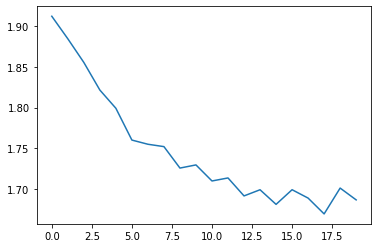

In [24]:
plt.plot(training_losses)